# Data Preprocessing and EDA

In [325]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer, OneHotEncoder
import seaborn as sns
%matplotlib inline

In [326]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [327]:
train.shape

(891, 12)

#### Removing `PassengerId`, `Name` and `Ticket`

`Name` and `PassengerId` do not have any effect on whether the person survived or not. The information from ticket is captured in its `Fare` value.

In [328]:
train.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)

## Imputing missing values

##### Which columns contain missing values?

In [329]:
train.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Cabin        True
Embarked     True
dtype: bool

We can see that `Age`, `Cabin`, and `Embarked` have missing values. If we have a lot of columns, we can directly get only the names of the columns which have missing values as follows.

In [330]:
miss_cols = train.columns[train.isnull().any()]
miss_cols

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

##### How many missing values are there in these columns?

In [331]:
train[miss_cols].isnull().sum()

Age         177
Cabin       687
Embarked      2
dtype: int64

In [332]:
# proportion of missing values in these columns
train[miss_cols].isnull().sum()/train.shape[0]

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64

Since, `Cabin` has more than 77% missing values, I decided to drop this variable.

In [333]:
train.drop('Cabin', axis = 1, inplace = True)

#### Age

Mean Age = 29.69911764705882
Median Age = 28.0


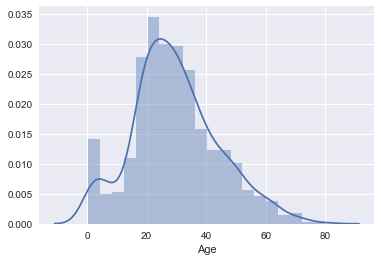

In [334]:
sns.distplot(train.Age.dropna())
print('Mean Age =', np.mean(train.Age))
print('Median Age =', np.median(train.Age.dropna()))

Since mean and median age are pretty close, this is a nicely distribute variable. It can also be seen from the histogram of Age. I will impute the missing values in Age with the mean.

In [335]:
age_imputer = Imputer(strategy = "mean")
train.Age = age_imputer.fit_transform(train.Age.values.reshape(-1,1))

#### Embarked

Since embarked is a categorical variable, we will use the most frequent value to impute the missing values.

In [336]:
# which category occurs the most frequently
train.Embarked.value_counts().argmax()

'S'

In [337]:
train.Embarked[train.Embarked.isnull()] = 'S'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Creating new variables

### Young

An indicator variable specifying whether the age is less than 18 or not.

In [338]:
train['Young'] = 0
train.Young[train.Age <= 18] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


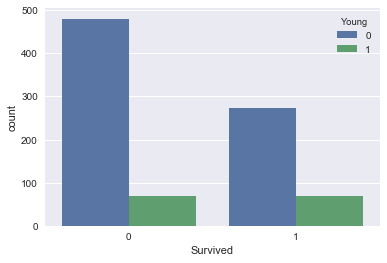

In [339]:
sns.countplot(x = 'Survived', hue = 'Young', data= train)

In [340]:
print(train.Survived[train.Young==1].value_counts(normalize=True))
print(train.Survived[train.Young==0].value_counts(normalize=True))

1    0.503597
0    0.496403
Name: Survived, dtype: float64
0    0.638298
1    0.361702
Name: Survived, dtype: float64


A young person had more than 50% chance of survival but an old person only had 36% chance of survival in the training data. This might play a role in the model.

## One Hot Encoding

Converting the categorical variables into numerical values first. This is required to use `scikit-learn`'s `OneHotEncoder` function becuase it doesn't recognize string variables.

In [341]:
train.Embarked = train.Embarked.astype("category").cat.codes
train.Sex = train.Sex.astype("category").cat.codes

Converting the numerical categorical variables into one hot encoded variables.

In [342]:
enc = OneHotEncoder()
sex_embarked = enc.fit_transform(train[['Sex', 'Embarked']]).toarray()

Removing the `Sex` and `Embarked` columns, transforming the pandas DataFrame into a numpy array and then appending the one hot encoded variables. We need to transform the data frame to a numpy array because the scikit-learn algorithms only accept numpy arrays as inputs.

In [343]:
train.drop(['Sex', 'Embarked'], axis = 1, inplace = True)

In [344]:
train = pd.concat([train, pd.DataFrame(sex_embarked)], axis = 1)

## Processing test data

Now, applying all these transformations (except dropping the `PassengerId` column because we need that to submit the file) to the test data before we can make predictions.

In [345]:
test.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test.Age = age_imputer.transform(test.Age.values.reshape(-1,1))
test.Embarked[test.Embarked.isnull()] = 'S'
test['Young'] = 0
test.Young[test.Age <= 18] = 1
test.Embarked = test.Embarked.astype("category").cat.codes
test.Sex = test.Sex.astype("category").cat.codes
test_sex_embarked = enc.transform(test[['Sex', 'Embarked']]).toarray()
test.drop(['Sex', 'Embarked'], axis = 1, inplace = True)
test = pd.concat([test, pd.DataFrame(test_sex_embarked)], axis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Writing the processed data

In [346]:
train.to_csv('clean_train.csv', index = False)
test.to_csv('clean_test.csv', index = False)